## Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [2]:
raw_data = yfinance.download (tickers = "SBIN.NS,YESBANK.NS,INDUSINDBK.NS,PNB.NS", start = "2010-04-01", 
                              end = "2020-03-27", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
#main stock
df_comp['INDUSINDBK'] = df_comp['INDUSINDBK.NS'].Close[:]
#influencing Stock
df_comp['SBIN'] = df_comp['SBIN.NS'].Close[:]
df_comp['YESBANK'] = df_comp['YESBANK.NS'].Close[:]
df_comp['PNB'] = df_comp['PNB.NS'].Close[:]



In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['PNB.NS']
del df_comp['YESBANK.NS']
del df_comp['INDUSINDBK.NS']
del df_comp['SBIN.NS']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [6]:
df_comp.head()

,SBIN,YESBANK,INDUSINDBK,PNB
,,,,
Date,,,,
2010-04-05,93.521843,33.912960,169.286942,99.848930
2010-04-06,92.878891,33.681908,168.865585,100.758369
2010-04-07,92.325615,33.431610,168.537903,98.988113
2010-04-08,91.669548,33.367424,167.133423,97.952232
2010-04-09,92.115677,33.842358,167.414337,97.884155


In [7]:
df_comp.tail()

,SBIN,YESBANK,INDUSINDBK,PNB
,,,,
Date,,,,
2020-03-20,209.850006,45.849998,440.350006,38.049999
2020-03-23,181.600006,39.750000,336.450012,35.400002
2020-03-24,183.199997,35.000000,312.350006,36.299999
2020-03-25,189.899994,29.600000,301.299988,34.299999
2020-03-26,192.750000,26.600000,435.899994,33.400002


## Creating Returns

In [9]:

df_comp['ret_SBIN'] = df_comp.SBIN.pct_change(1).mul(100)
df_comp['ret_INDUSINDBK'] = df_comp.INDUSINDBK.pct_change(1).mul(100)
df_comp['ret_YESBANK'] = df_comp.YESBANK.pct_change(1).mul(100)
df_comp['ret_PNB'] = df_comp.PNB.pct_change(1).mul(100)


In [10]:
df_comp['norm_ret_SBIN'] = df_comp.ret_SBIN.div(df_comp.ret_SBIN[1])*100
df_comp['norm_ret_INDUSINDBK'] = df_comp.ret_INDUSINDBK.div(df_comp.ret_INDUSINDBK[1])*100
df_comp['norm_ret_YESBANK'] = df_comp.ret_YESBANK.div(df_comp.ret_YESBANK[1])*100
df_comp['norm_ret_PNB'] = df_comp.ret_PNB.div(df_comp.ret_PNB[1])*100



## Splitting the Data

In [11]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [14]:
model_ar = ARIMA(df.INDUSINDBK, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [15]:
df.tail()

,SBIN,YESBANK,INDUSINDBK,PNB,ret_SBIN,ret_INDUSINDBK,ret_YESBANK,ret_PNB,norm_ret_SBIN,norm_ret_INDUSINDBK,norm_ret_YESBANK,norm_ret_PNB
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2018-03-22,241.550003,287.989868,1730.351562,96.550003,-2.600805,1.250401,-0.831257,-1.075815,378.305240,-502.369807,122.008573,-118.115637
2018-03-23,234.800003,276.788910,1726.798340,93.150002,-2.794452,-0.205347,-3.889358,-3.521493,406.472580,82.501556,570.864697,-386.630954
2018-03-26,246.500000,292.914459,1736.915283,95.800003,4.982963,0.585879,5.825938,2.844875,-724.806666,-235.386616,-855.108157,312.343921
2018-03-27,254.350006,293.059265,1764.995972,99.449997,3.184587,1.616699,0.049436,3.810014,-463.220317,-649.535936,-7.256057,418.308237
2018-03-28,249.899994,294.362823,1773.435059,95.300003,-1.749562,0.478136,0.444810,-4.172945,254.486048,-192.099312,-65.287530,-458.155057


In [16]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2018-02-12"
end_date = "2018-03-26"

In [17]:
end_date = "2020-03-26"
df_pred = results_ar.predict(start = start_date, end = end_date)

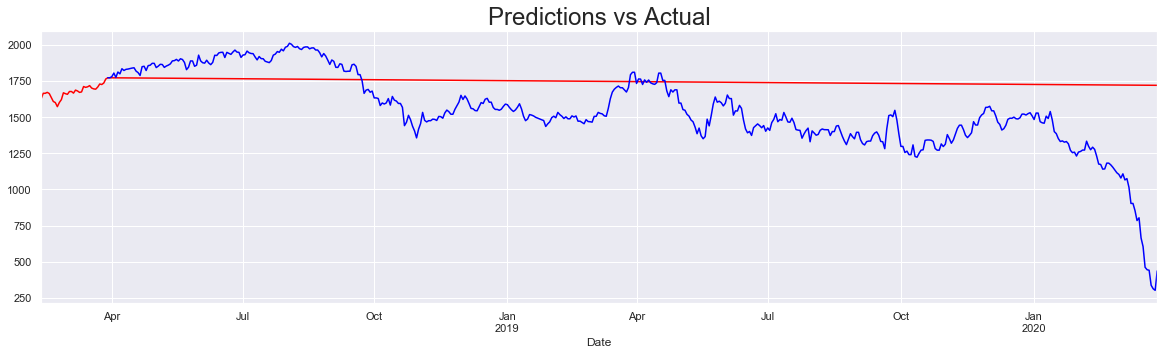

In [20]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

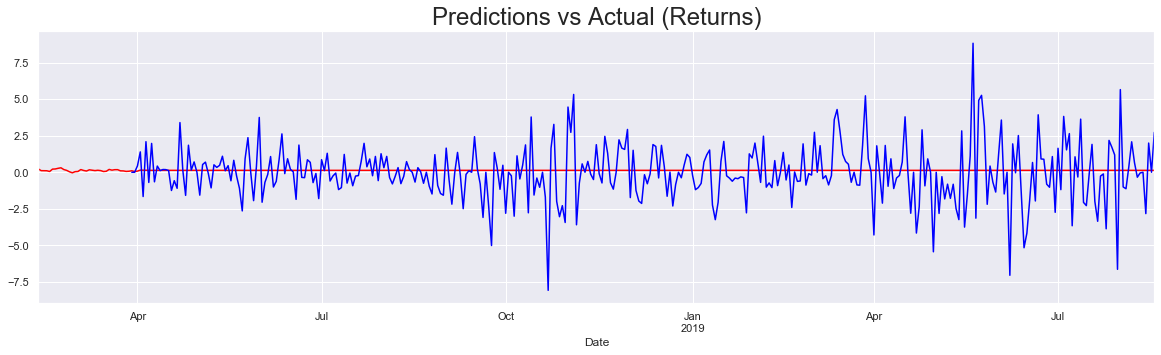

In [22]:
end_date = "2019-08-18"

model_ret_ar = ARIMA(df.ret_INDUSINDBK[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [23]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         ret_INDUSINDBK   No. Observations:                 2082
Model:                     ARMA(5, 0)   Log Likelihood               -4290.800
Method:                       css-mle   S.D. of innovations              1.900
Date:                Fri, 27 Mar 2020   AIC                           8595.599
Time:                        13:29:00   BIC                           8635.087
Sample:                    04-06-2010   HQIC                          8610.069
                         - 03-28-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1310      0.038      3.458      0.001       0.057       0.205
ar.L1.ret_INDUSINDBK    -0.0248      0.022     -1.132      0.258      -0.068       0.018
ar.L2.ret_INDUSINDBK    -0.0207      0.022     -0.947      0.344      -0.064       0.022
ar.L3.ret_INDUSINDBK    -0.0355      0.022     -1.624      0.104      -0.078       0.007
ar.L4.ret_INDUSINDBK    -0.0331      0.022     -1.511      0.131      -0.076       0.010
ar.L5.ret_INDUSINDBK     0.0145      0.022      0.661      0.509      -0.028       0.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6550           -1.2677j            2.0847           -0.3960
AR.2           -1.6550           +1.2677j            2.0847            0.3960
AR.3            1.0188           -1.8525j            2.1141           -0.1700
AR.4            1.0188           +1.8525j            2.1141            0.1700
AR.5            3.5596           -0.0000j            3.5596           -0.0000
-----------------------------------------------------------------------------
"""

### MA

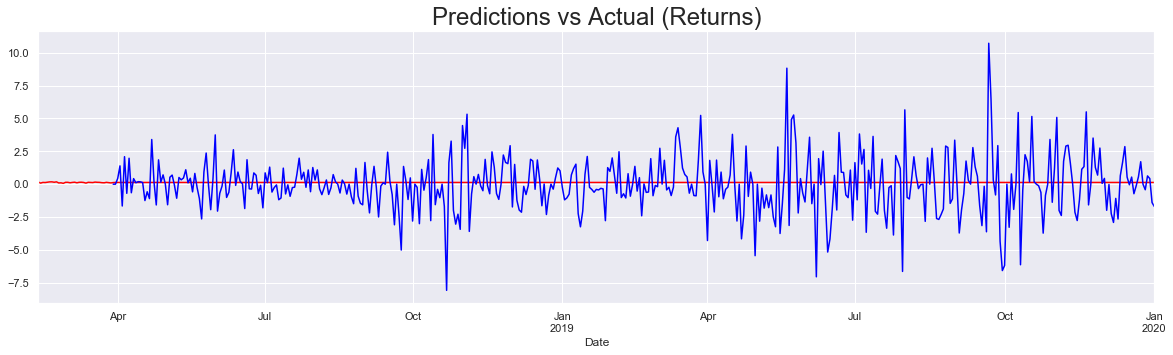

In [24]:
end_date = "2020-01-01"

model_ret_ma = ARIMA(df.ret_INDUSINDBK[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [25]:
df_pred_ma.head()

2018-02-12    0.164005
2018-02-13    0.079810
2018-02-14    0.132892
2018-02-15    0.124726
2018-02-16    0.145702
Freq: B, dtype: float64

### ARMA

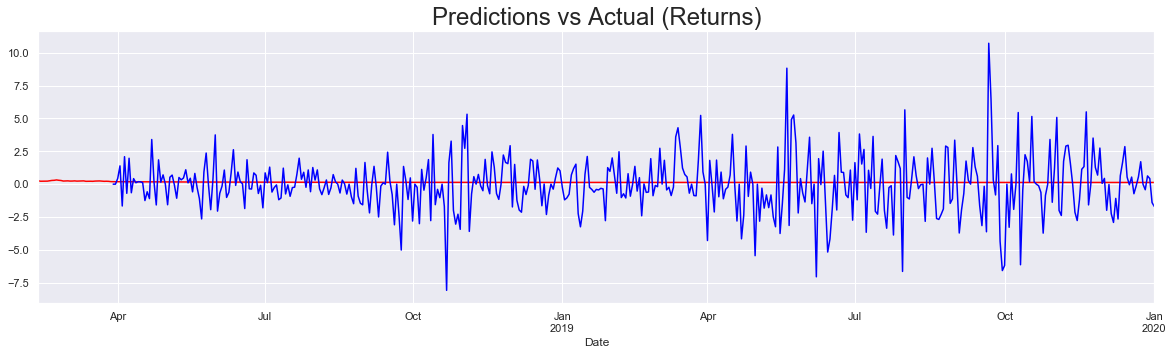

In [26]:
model_ret_arma = ARIMA(df.ret_INDUSINDBK[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [27]:
df_pred_arma.head()

2018-02-12    0.256337
2018-02-13    0.223691
2018-02-14    0.225616
2018-02-15    0.221621
2018-02-16    0.230906
Freq: B, dtype: float64

In [28]:
df_pred_arma.tail()

2019-12-26    0.131016
2019-12-27    0.131015
2019-12-30    0.131015
2019-12-31    0.131014
2020-01-01    0.131013
Freq: B, dtype: float64

### ARMAX

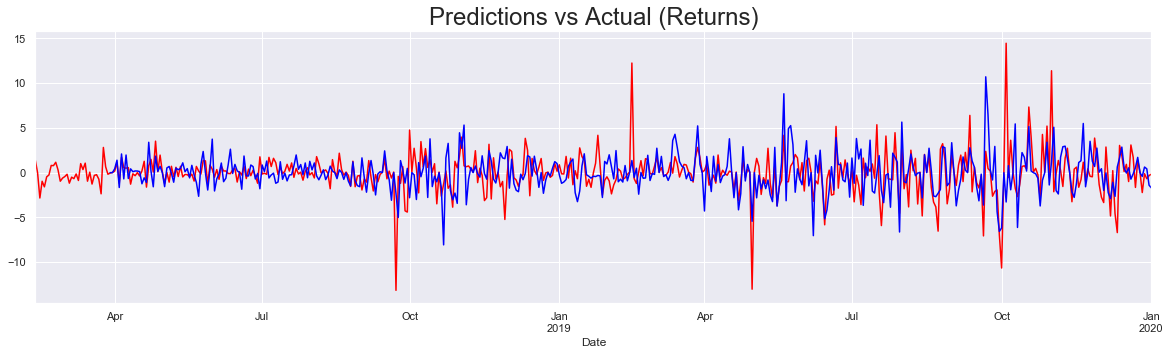

In [29]:
model_ret_armax = ARIMA(df.ret_INDUSINDBK[1:], exog = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

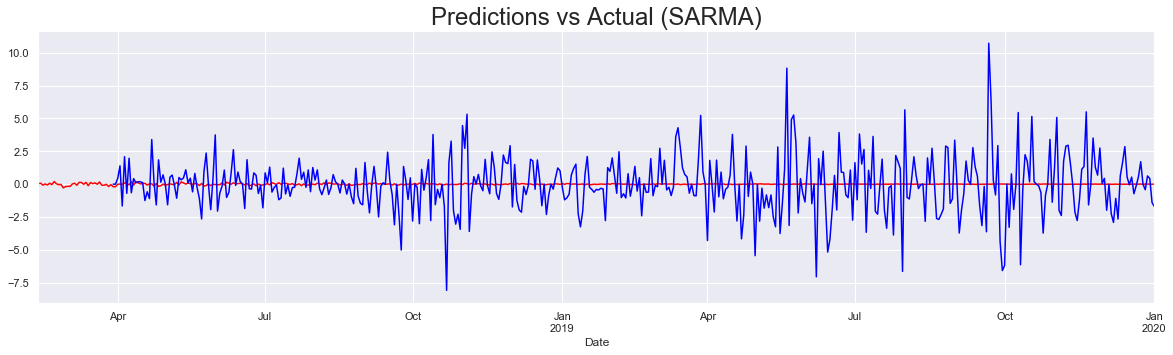

In [30]:
end_date = "2020-01-01"
model_ret_sarma = SARIMAX(df.ret_INDUSINDBK[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

In [63]:
df_test.head()

,SBIN,YESBANK,INDUSINDBK,PNB,ret_SBIN,ret_INDUSINDBK,ret_YESBANK,ret_PNB,norm_ret_SBIN,norm_ret_INDUSINDBK,norm_ret_YESBANK,norm_ret_PNB
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2018-03-29,249.899994,294.362823,1773.435059,95.300003,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
2018-03-30,249.899994,294.362823,1773.435059,95.300003,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
2018-04-02,246.149994,295.714661,1781.183350,96.300003,-1.500600,0.436909,0.459242,1.049318,218.272765,-175.535396,-67.405702,115.206474
2018-04-03,250.500000,302.329010,1805.957642,95.449997,1.767218,1.390889,2.236734,-0.882665,-257.054118,-558.813249,-328.298948,-96.909320
2018-04-04,247.300003,294.942200,1776.001343,94.400002,-1.277444,-1.658749,-2.443302,-1.100048,185.813114,666.430191,358.618212,-120.776180


### SARIMAX

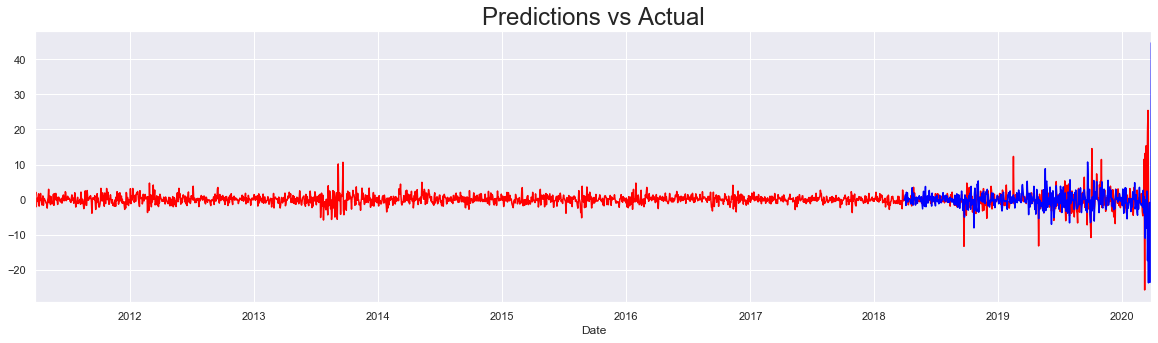

In [65]:
start_date="2011-03-29"
end_date = "2020-03-26"
model_ret_sarimax = SARIMAX(df.ret_INDUSINDBK[1:], exog = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()



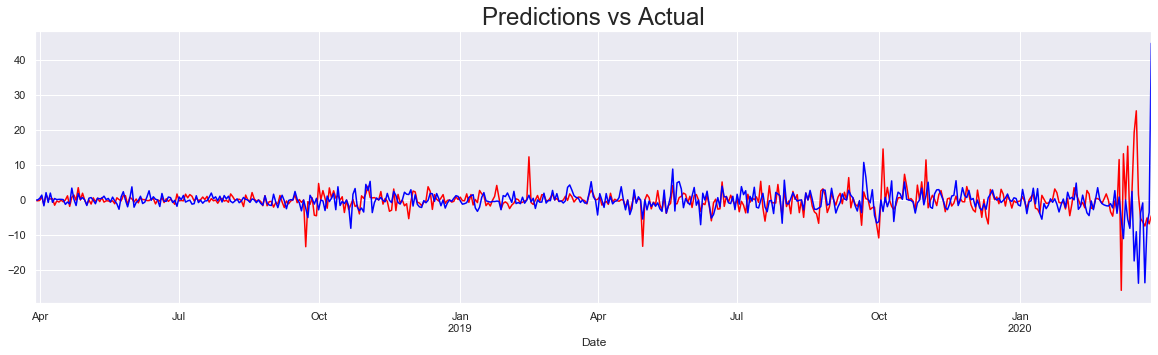

In [66]:
start_date="2018-03-29"

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 


df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [67]:
model_auto = auto_arima(df.ret_INDUSINDBK[1:], exogenous = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [68]:
start_date="2018-03-29"
end_date = "2020-03-26"
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

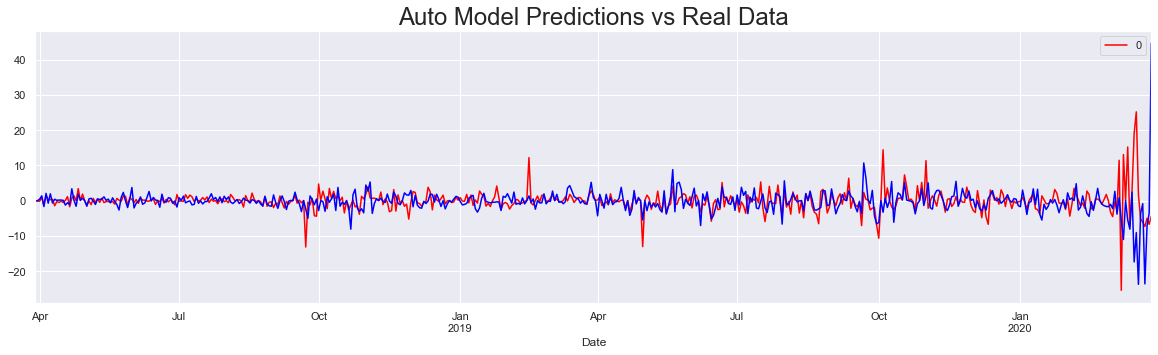

In [69]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

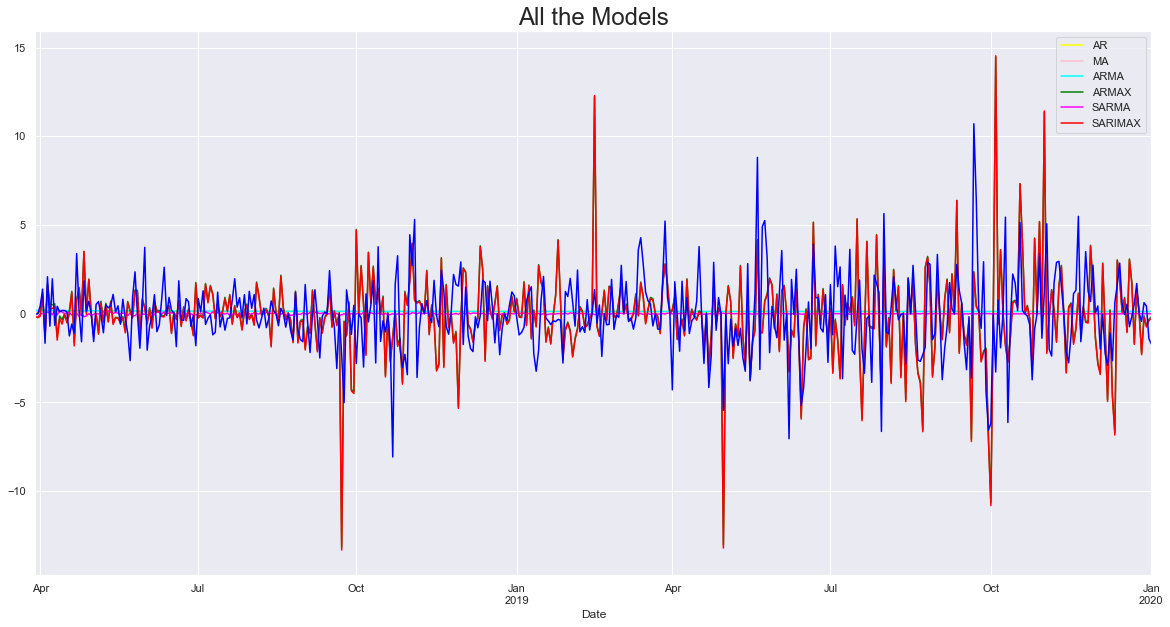

In [70]:
end_date = "2020-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [71]:
mod_garch = arch_model(df_comp.ret_INDUSINDBK[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     73,   Neg. LLF: 4140.413398556159
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4140.412994816887
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


In [72]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

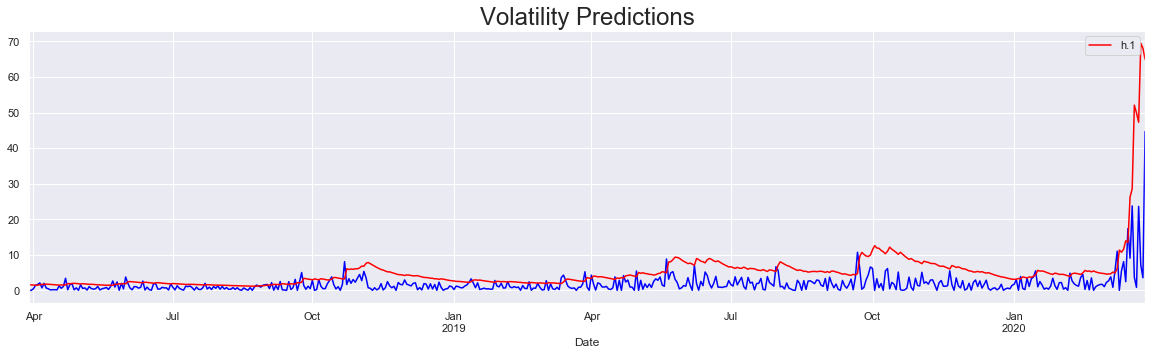

In [73]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_INDUSINDBK.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [74]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-26,64.983237,67.369259,68.055461,45.848844,47.926289,49.508511,26.973485,24.57504,12.622367,12.976282,...,4.758019,4.387418,4.46731,4.557854,4.638155,4.60945,4.634233,4.745575,4.830455,4.826132


### Multvariate Regression Model

In [75]:
from statsmodels.tsa.api import VAR

In [76]:
df_ret = df[["ret_SBIN","ret_YESBANK","ret_PNB","ret_INDUSINDBK"]][1:]

In [78]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [79]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Mar, 2020
Time:                     14:23:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    5.15022
Nobs:                     2081.00    HQIC:                   5.11587
Log likelihood:          -17093.6    FPE:                    163.369
AIC:                      5.09601    Det(Omega_mle):         161.808
--------------------------------------------------------------------
Results for equation ret_SBIN
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.058282         0.048306            1.207           0.228
L1.ret_SBIN               0.023888         0.030368            0.787           0.432
L1.ret_YESBANK            0.032196       

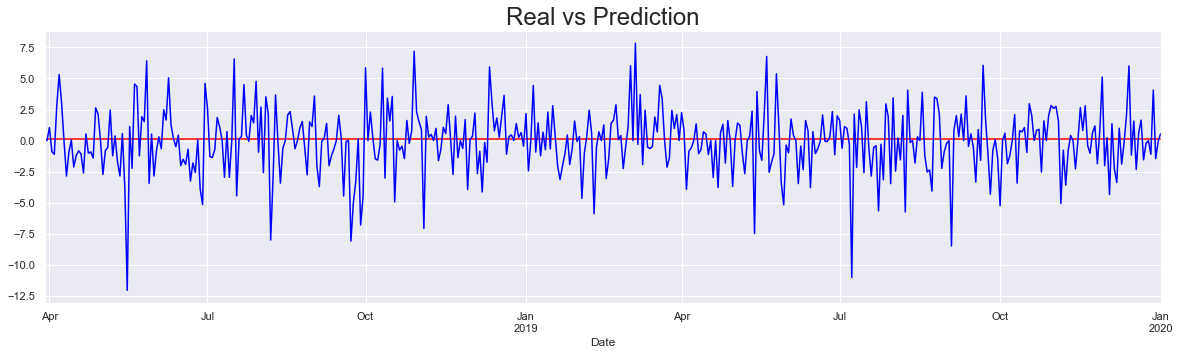

In [80]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_PNB[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_PNB[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

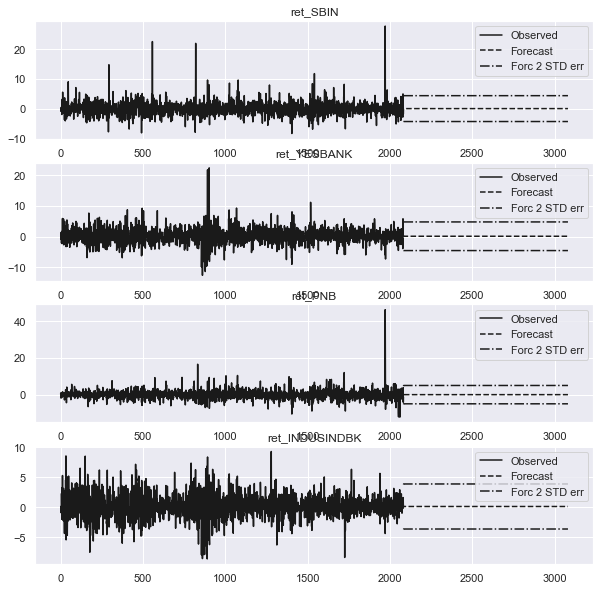

In [81]:
results_var_ret.plot_forecast(1000)
plt.show()